In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
import os

In [13]:
# Load Datasets
train_data = pd.read_csv('data/train-dataset.csv')
test_data = pd.read_csv('data/test-dataset.csv')
dev_data = pd.read_csv('data/dev-dataset.csv')

In [3]:
x_train = train_data.drop('TROPTHSMesswert', axis=1)
y_train = train_data['TROPTHSMesswert']

x_test = test_data.drop('TROPTHSMesswert', axis=1)
y_test = test_data['TROPTHSMesswert']

x_dev = dev_data.drop('TROPTHSMesswert', axis=1)
y_dev = dev_data['TROPTHSMesswert']

In [14]:
# Define models to train
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'Support Vector Machine': SVR(),
    'Decision Tree': DecisionTreeRegressor(),
    'Baggigng Regressor': BaggingRegressor()
}

### Plotting Feature importance for some models

Linear Regression does not support feature importance.
Error with Random Forest: The number of FixedLocator locations (20), usually from a call to set_ticks, does not match the number of labels (99).
Support Vector Machine does not support feature importance.
Error with Decision Tree: The number of FixedLocator locations (20), usually from a call to set_ticks, does not match the number of labels (99).
Baggigng Regressor does not support feature importance.

Model evaluation on the dev set:
Linear Regression:
  Mean Squared Error = 0.0000
  Mean Absolute Error = 0.0011
  R Squared = 1.0000

Random Forest:
  Mean Squared Error = 0.7211
  Mean Absolute Error = 0.6078
  R Squared = 0.8094

Support Vector Machine:
  Mean Squared Error = 2.5844
  Mean Absolute Error = 1.1200
  R Squared = 0.3168

Decision Tree:
  Mean Squared Error = 1.8006
  Mean Absolute Error = 0.7771
  R Squared = 0.5240

Baggigng Regressor:
  Mean Squared Error = 0.8332
  Mean Absolute Error = 0.6418
  R Squared = 0.779

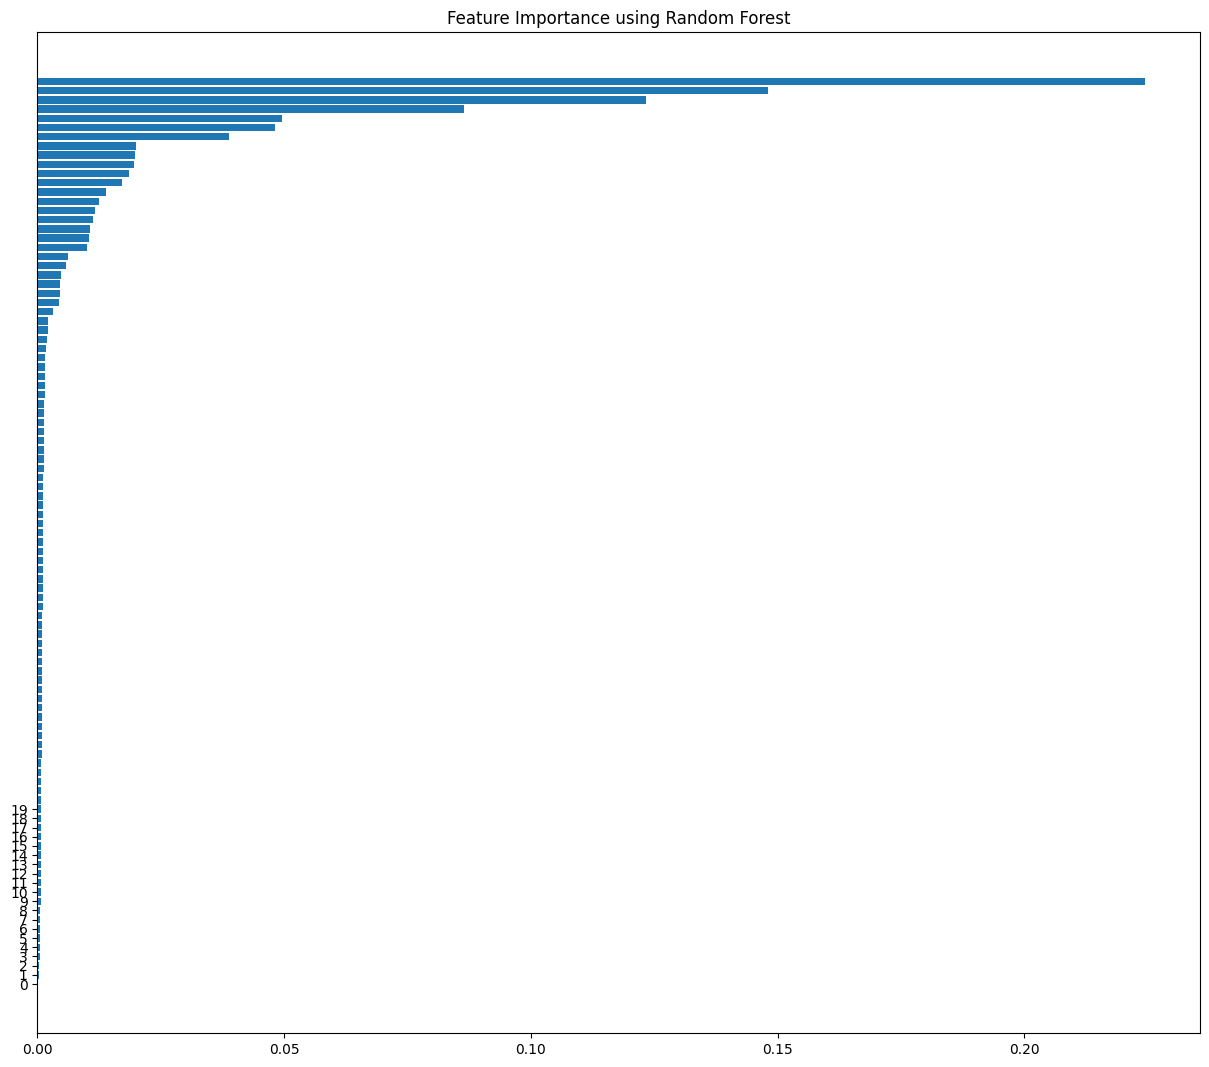

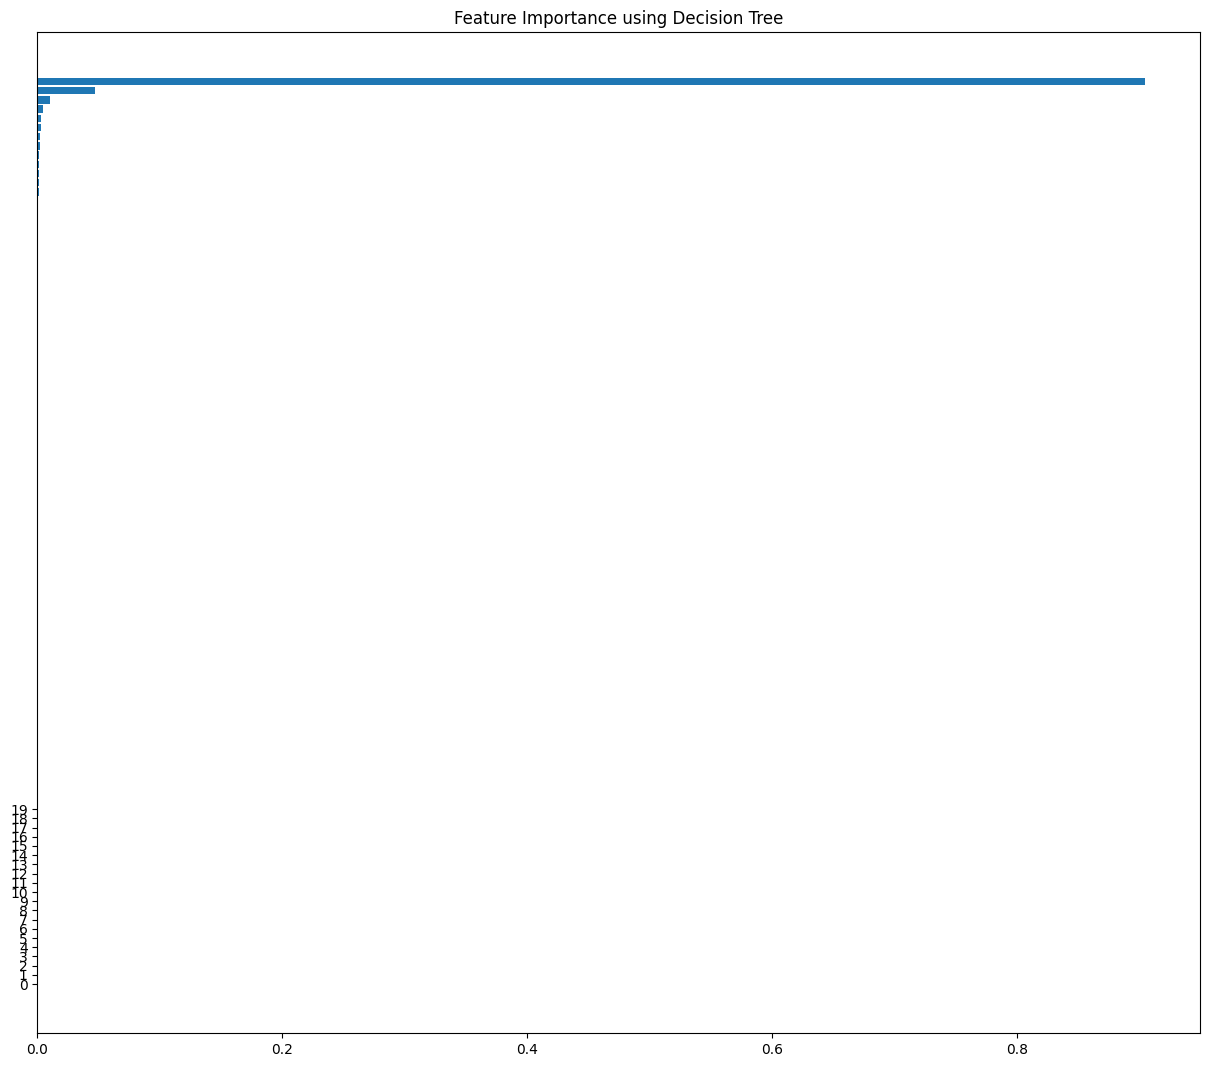

In [15]:
# Ensure plot directory exists
plot_dir = "Feature-Importance-Plots-Regressions"
os.makedirs(plot_dir, exist_ok=True)

# Variables to track the best model and feature importance
best_model = None
best_r2 = float("-inf")  # Start with the worst R^2
model_results = {}
feature_importances = {}

# Loop through each model and evaluate
for model_name, model in models.items():
    try:
        # Fit model and predict
        model.fit(x_train, y_train)
        y_dev_pred = model.predict(x_dev)

        # Calculate metrics
        mse = mean_squared_error(y_dev, y_dev_pred)
        mae = mean_absolute_error(y_dev, y_dev_pred)
        r2 = r2_score(y_dev, y_dev_pred)

        # Store results
        model_results[model_name] = {
            'Mean Squared Error': mse,
            'Mean Absolute Error': mae,
            'R Squared': r2
        }

        # Update best model based on R^2
        if r2 > best_r2:
            best_r2 = r2
            best_model = model

        # Handle feature importances if available
        if hasattr(model, "feature_importances_"):
            feature_importances[model_name] = model.feature_importances_
            importances = feature_importances[model_name]
            feature_names = train_data.columns.drop('TROPTHSMesswert')  # Feature names
            indices = np.argsort(importances)

            # Plot feature importance
            plt.figure(figsize=(15, 13))
            plt.title(f"Feature Importance using {model_name}")
            plt.barh(range(len(indices)), importances[indices], align="center")
            plt.yticks(range(20), [feature_names[i] for i in indices])
            plt.xlabel("Feature Importance")
            plt.tight_layout()

            # Export the plot
            plot_filename = f"{model_name}_feature_importance.png"
            plt.savefig(os.path.join(plot_dir, plot_filename))
            plt.close()
        else:
            print(f"{model_name} does not support feature importance.")
    except Exception as e:
        print(f"Error with {model_name}: {e}")

# Print evaluation results
print("\nModel evaluation on the dev set:")
for model_name, metrics in model_results.items():
    print(f"{model_name}:")
    print(f"  Mean Squared Error = {metrics['Mean Squared Error']:.4f}")
    print(f"  Mean Absolute Error = {metrics['Mean Absolute Error']:.4f}")
    print(f"  R Squared = {metrics['R Squared']:.4f}\n")


### Functions to select most important features and evaluate models

In [6]:
# apply features that work best for different models
def apply_feature_importance(model):
    model.fit(x_train, y_train)  

    selector = SelectFromModel(model, threshold="mean", prefit=True)

    x_train_selected = selector.transform(x_train)  
    x_test_selected = selector.transform(x_test)
    x_dev_selected = selector.transform(x_dev)

    selected_features = selector.get_support(indices=True)
    print(f"Number of selected features: {len(selected_features)}")
    print(f"Selected feature names: {feature_names[selected_features]}")

    return x_train_selected, x_test_selected, x_dev_selected

# evaluate respective model
def evaluate_models (model_name, retrained_model, x_test_selected):
    y_test_pred = retrained_model.predict(x_test_selected)
    mse = mean_squared_error(y_test, y_test_pred)
    mae = mean_absolute_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)

    print(f"Retrained {model_name} Performance on Test Set: Mean Squared Error = {mse:.4f}\n, Mean Absolute Error = {mae:.4f}\n, R Score = {r2:.4f}\n")

### Linear Regression

In [7]:
#Linear Regressor
init_model = LinearRegression()
x_train_selected, x_test_selected, x_dev_selected = apply_feature_importance(init_model)

#Train Linear Regressor with feature importance
retrained_model = LinearRegression()
retrained_model.fit(x_train_selected, y_train)

evaluate_models('Linear Regression', retrained_model, x_test_selected)

Number of selected features: 5
Selected feature names: Index(['BASO_RESEARCHValue', 'EO_RESEARCHValue', 'LYMPH_RESEARCHValue',
       'MONO_RESEARCHValue', 'NEUT_RESEARCHValue'],
      dtype='object')
Retrained Linear Regression Performance on Test Set: Mean Squared Error = 3.6553
, Mean Absolute Error = 1.5724
, R Score = -0.0109



/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


### Random Forest Regressor

In [8]:
# Random Forest Regressor
init_model = RandomForestRegressor()
x_train_selected, x_test_selected, x_dev_selected = apply_feature_importance(init_model)

#Train Random Forest with feature importance
retrained_model = RandomForestRegressor()
retrained_model.fit(x_train_selected, y_train)

evaluate_models('Random Forest Regressor', retrained_model, x_test_selected)



/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Number of selected features: 18
Selected feature names: Index(['APHMesswert', 'BIGMesswert', 'CAKORRMesswert', 'CRPMesswert',
       'FEMesswert', 'GEMesswert', 'GGT37Messwert', 'GLUCMesswert',
       'HDLMesswert', 'HSTMesswert', 'INTER6Messwert', 'LDH37Messwert',
       'nFT4Messwert', 'PMesswert', 'PROBNPMesswert', 'PTTAFMesswert',
       'QUIMesswert', 'TRNMesswert'],
      dtype='object')
Retrained Random Forest Regressor Performance on Test Set: Mean Squared Error = 0.7767
, Mean Absolute Error = 0.6186
, R Score = 0.7852



### SVM

In [9]:
from sklearn.linear_model import Lasso
# Support Vector Machine
feature_sel = Lasso(alpha=0.01)
x_train_selected, x_test_selected, x_dev_selected = apply_feature_importance(feature_sel)

#Train Support Vector Regressor with feature importance
retrained_model = SVR()
retrained_model.fit(x_train_selected, y_train)

evaluate_models('Support Vector Machine', retrained_model, x_test_selected)


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.778e+03, tolerance: 4.841e+01
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Number of selected features: 15
Selected feature names: Index(['ALBMesswert', 'BIGMesswert', 'CLMesswert', 'FT3RMesswert',
       'GEMesswert', 'HSMesswert', 'IG#_RESEARCHValue', 'INRQMesswert',
       'KRCMesswert', 'KRCOMPMesswert', 'LYXValue', 'NEUT#_RESEARCHValue',
       'nFT4Messwert', 'NRBCValue', 'PMesswert'],
      dtype='object')
Retrained Support Vector Machine Performance on Test Set: Mean Squared Error = 2.4726
, Mean Absolute Error = 1.1263
, R Score = 0.3162



### Decision Tree Regressor

In [10]:

# Decision Tree Regressor
init_model = DecisionTreeRegressor()
x_train_selected, x_test_selected, x_dev_selected = apply_feature_importance(init_model)

#Train Decision Tree Regressor with feature importance
retrained_model = DecisionTreeRegressor()
retrained_model.fit(x_train_selected, y_train)

evaluate_models('Decision Tree Regressor', retrained_model, x_test_selected)


Number of selected features: 2
Selected feature names: Index(['INTER6Messwert', 'PROBNPMesswert'], dtype='object')
Retrained Decision Tree Regressor Performance on Test Set: Mean Squared Error = 3.0906
, Mean Absolute Error = 1.1036
, R Score = 0.1453



/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


### Bagging Regressor 

In [11]:
# Baggigng Regressor
print (f"Used the same features as for Decision Tree Regression.")

#Train Bagging Regressor with feature importance
retrained_model = BaggingRegressor()
retrained_model.fit(x_train_selected, y_train)

evaluate_models('Baggigng Regressor', retrained_model, x_test_selected)

Used the same features as for Decision Tree Regression.
Retrained Baggigng Regressor Performance on Test Set: Mean Squared Error = 1.8271
, Mean Absolute Error = 0.9458
, R Score = 0.4947

